# Is it a bird?

> This notebook is following the first lesson in the [fast ai Practical Deep Learning for Coders course](https://course.fast.ai/Lessons/lesson1.html)

The resources related are as following:
1. [Lesson 1 lecture](https://www.youtube.com/watch?v=8SF_h3xF3cE)
2. [Deep Learning for Coders with Fastai and PyTorch: AI Applications Without a PhD Chapter 1](https://github.com/fastai/fastbook/blob/master/01_intro.ipynb)
3. [Course notebooks](https://github.com/fastai/course22/blob/master/00-is-it-a-bird-creating-a-model-from-your-own-data.ipynb)

In [ ]:
#| default_exp bird_classifier

In [ ]:
#| hide
from nbdev.showdoc import *

In [ ]:
# Suppress only UserWarning
import warnings

warnings.filterwarnings('ignore', category=UserWarning)

**Detect if notebook is running on Kaggle**

It's a good idea to ensure you're running the latest version of any libraries you need.
`!pip install -Uqq <libraries>` upgrades to the latest version of <libraries>

In [ ]:
import os
iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')

if iskaggle:
    print('Is running on Kaggle.')
    !pip install -Uqq fastai

## Step 1: Download images of birds and non-birds

In [ ]:
# Skip this cell if you already have duckduckgo_search installed
!pip install -Uqq duckduckgo_search > /dev/null
!pip install -Uqq fastai > /dev/null
!pip install fastdownload  > /dev/null

In [ ]:
from duckduckgo_search import DDGS 
from fastcore.all import *

def search_images(keywords, max_images=200): return L(DDGS().images(keywords, max_results=max_images)).itemgot('image')

Let's start by searching for a bird photo and seeing what kind of result we get. We'll start by getting URLs from a search:

In [ ]:
# to test, we can run the following code

#urls = search_images('bird photos', max_images=1)
#urls[0]

...and then download a URL and take a look at it:

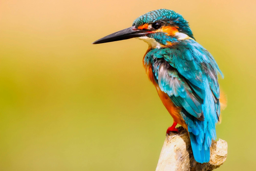

In [ ]:
dest = 'bird.jpg'
bird_path = Path(dest)

if not bird_path.exists():
    from fastdownload import download_url
    download_url(urls[0], dest, show_progress=False)

from fastai.vision.all import *
im = Image.open(dest)
im.to_thumb(256,256)

Now let's do the same with "forest photos":

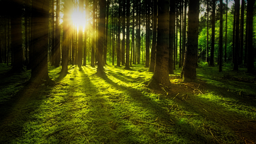

In [ ]:
forest_dest= 'forest.jpg'
forest_path = Path(forest_dest)

if not forest_path.exists():
    download_url(search_images('forest photos', max_images=1)[0], forest_dest, show_progress=False)
    
Image.open(forest_dest).to_thumb(256,256)

Our searches seem to be giving reasonable results, so let's grab 200 examples of each of "bird" and "forest" photos, and save each group of photos to a different folder:

In [ ]:
searches = 'forest','bird'
path = Path('bird_or_not')

for o in searches:
    dest = (path/o)

    if dest.exists():
        print(f"Directory '{dest}' already exists. Skipping search, download, and resize for '{o}'.")
        continue # Skip the rest of this loop iteration and move to the next search term
        
    dest.mkdir(exist_ok=True, parents=True)
    results = search_images(f'{o} photo')
    download_images(dest, urls=results[:200])
    time.sleep(5)
    resize_images(dest, max_size=400, dest=dest)

Directory 'bird_or_not/forest' already exists. Skipping search, download, and resize for 'forest'.
Directory 'bird_or_not/bird' already exists. Skipping search, download, and resize for 'bird'.


## Step 2: Train our model
Some photos might not download correctly which could cause our model training to fail, so we'll remove them:

In [ ]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

0

To train a model, we'll need `DataLoaders`, which is an object that contains a training set (the images used to create a model) and a validation set (the images used to check the accuracy of a model -- not used during training). In `fastai` we can create that easily using a `DataBlock`, and view sample images from it:

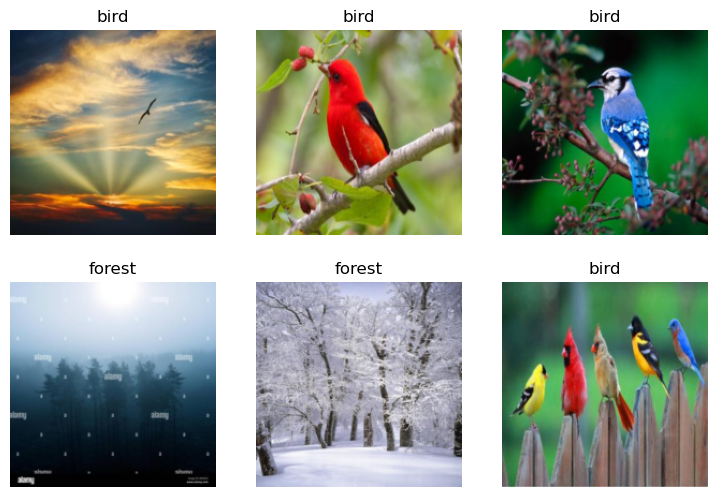

In [ ]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path, bs=32)

dls.show_batch(max_n=6)

In [ ]:
num_bird_photos = len(get_image_files(path/'bird'))
print(f'{num_bird_photos} bird photos exist in dataset')

num_forest_photos = len(get_image_files(path/'forest'))
print(f'{num_forest_photos} forest photos exist in dataset')

185 bird photos exist in dataset
193 forest photos exist in dataset


Now we're ready to train our model. The fastest widely used computer vision model is resnet18. You can train this in a few minutes, even on a CPU! (On a GPU, it generally takes under 10 seconds...)

`fastai` comes with a helpful `fine_tune()` method which automatically uses best practices for fine tuning a pre-trained model, so we'll use that.

In [ ]:
model_path= Path('bird.pkl')
model_existed=False

if model_path.exists():
    print(f"Loading existing model weights from: {model_path}")
    # Load the saved weights into the existing learner structure
    learn = load_learner('bird.pkl')    
    learn.dls = dls
        
    model_existed=True
else:
    learn = vision_learner(dls, resnet18, metrics=error_rate)
    learn.fine_tune(3)
    model_existed= False

Loading existing model weights from: bird.pkl


## Step 3: Use our model (and build your own!)

Let's see what our model thinks about that bird we downloaded at the start:

In [ ]:
is_bird,_,probs = learn.predict(PILImage.create('bird.jpg'))
print(f"This is a: {is_bird}.")
print(f"Probability it's a bird: {probs[0]:.4f}")

This is a: bird.
Probability it's a bird: 1.0000


In [ ]:
if not model_existed:
    learn.export('bird.pkl')

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()